# **Granger Causality Test - Bence Pal, Rita Naumenko**

### **1.1 Importing Packages & Loading Data**

In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from IPython.display import Markdown, display
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson

import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Increase resolution and set the style for plotting
plt.rcParams['figure.dpi'] = 300
sns.set_style('whitegrid')

We chose to work with the stock price data of Apple (AAPL), Walmart (WMT), and Tesla (TSLA) to determine whether data from one leading U.S. company could be used to forecast the stock prices of another.

In [3]:
# Data download
aapl = yf.download("AAPL", start="2014-11-01", end = "2024-11-01")
tsla = yf.download("TSLA", start="2014-11-01", end = "2024-11-01")
wmt = yf.download("WMT", start="2014-11-01", end = "2024-11-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# We will work with the daily closing prices of each stock for the analysis
# We need the 'Adj Close' column
aapl = aapl.loc[:, 'Adj Close']
wmt = wmt.loc[:, 'Adj Close']
tsla = tsla.loc[:, 'Adj Close']
aapl.head()

Date
2014-11-03    24.257572
2014-11-04    24.080187
2014-11-05    24.137835
2014-11-06    24.206869
2014-11-07    24.275911
Name: Adj Close, dtype: float64

In [5]:
df = pd.merge(aapl, wmt, on=aapl.index)
df.rename(columns={'key_0': 'Date', 'Adj Close_x': 'AAPL', 'Adj Close_y': 'WMT'}, inplace=True)
df = df.merge(tsla, on=df['Date'])
df.drop(columns={'key_0'}, inplace=True)
df.rename(columns={'Adj Close': 'TSLA'}, inplace=True)
df.set_index('Date', inplace=True)
df.head()

,AAPL,WMT,TSLA
Date,,,
2014-11-03,24.257572,20.746477,16.172667
2014-11-04,24.080187,21.013014,15.928667
2014-11-05,24.137835,21.132689,15.398000
2014-11-06,24.206869,21.162611,16.081333
2014-11-07,24.275911,21.423702,16.013332


### **1.2 Plotting Data & Checking Stationarity**

Before we run the Granger Causality test, we have to ensure that our data meet the assumptions of this test.

The key assumption of Granger Causality test is that the time series of interest are stationary.

First, we plot our data to inspect it visually:

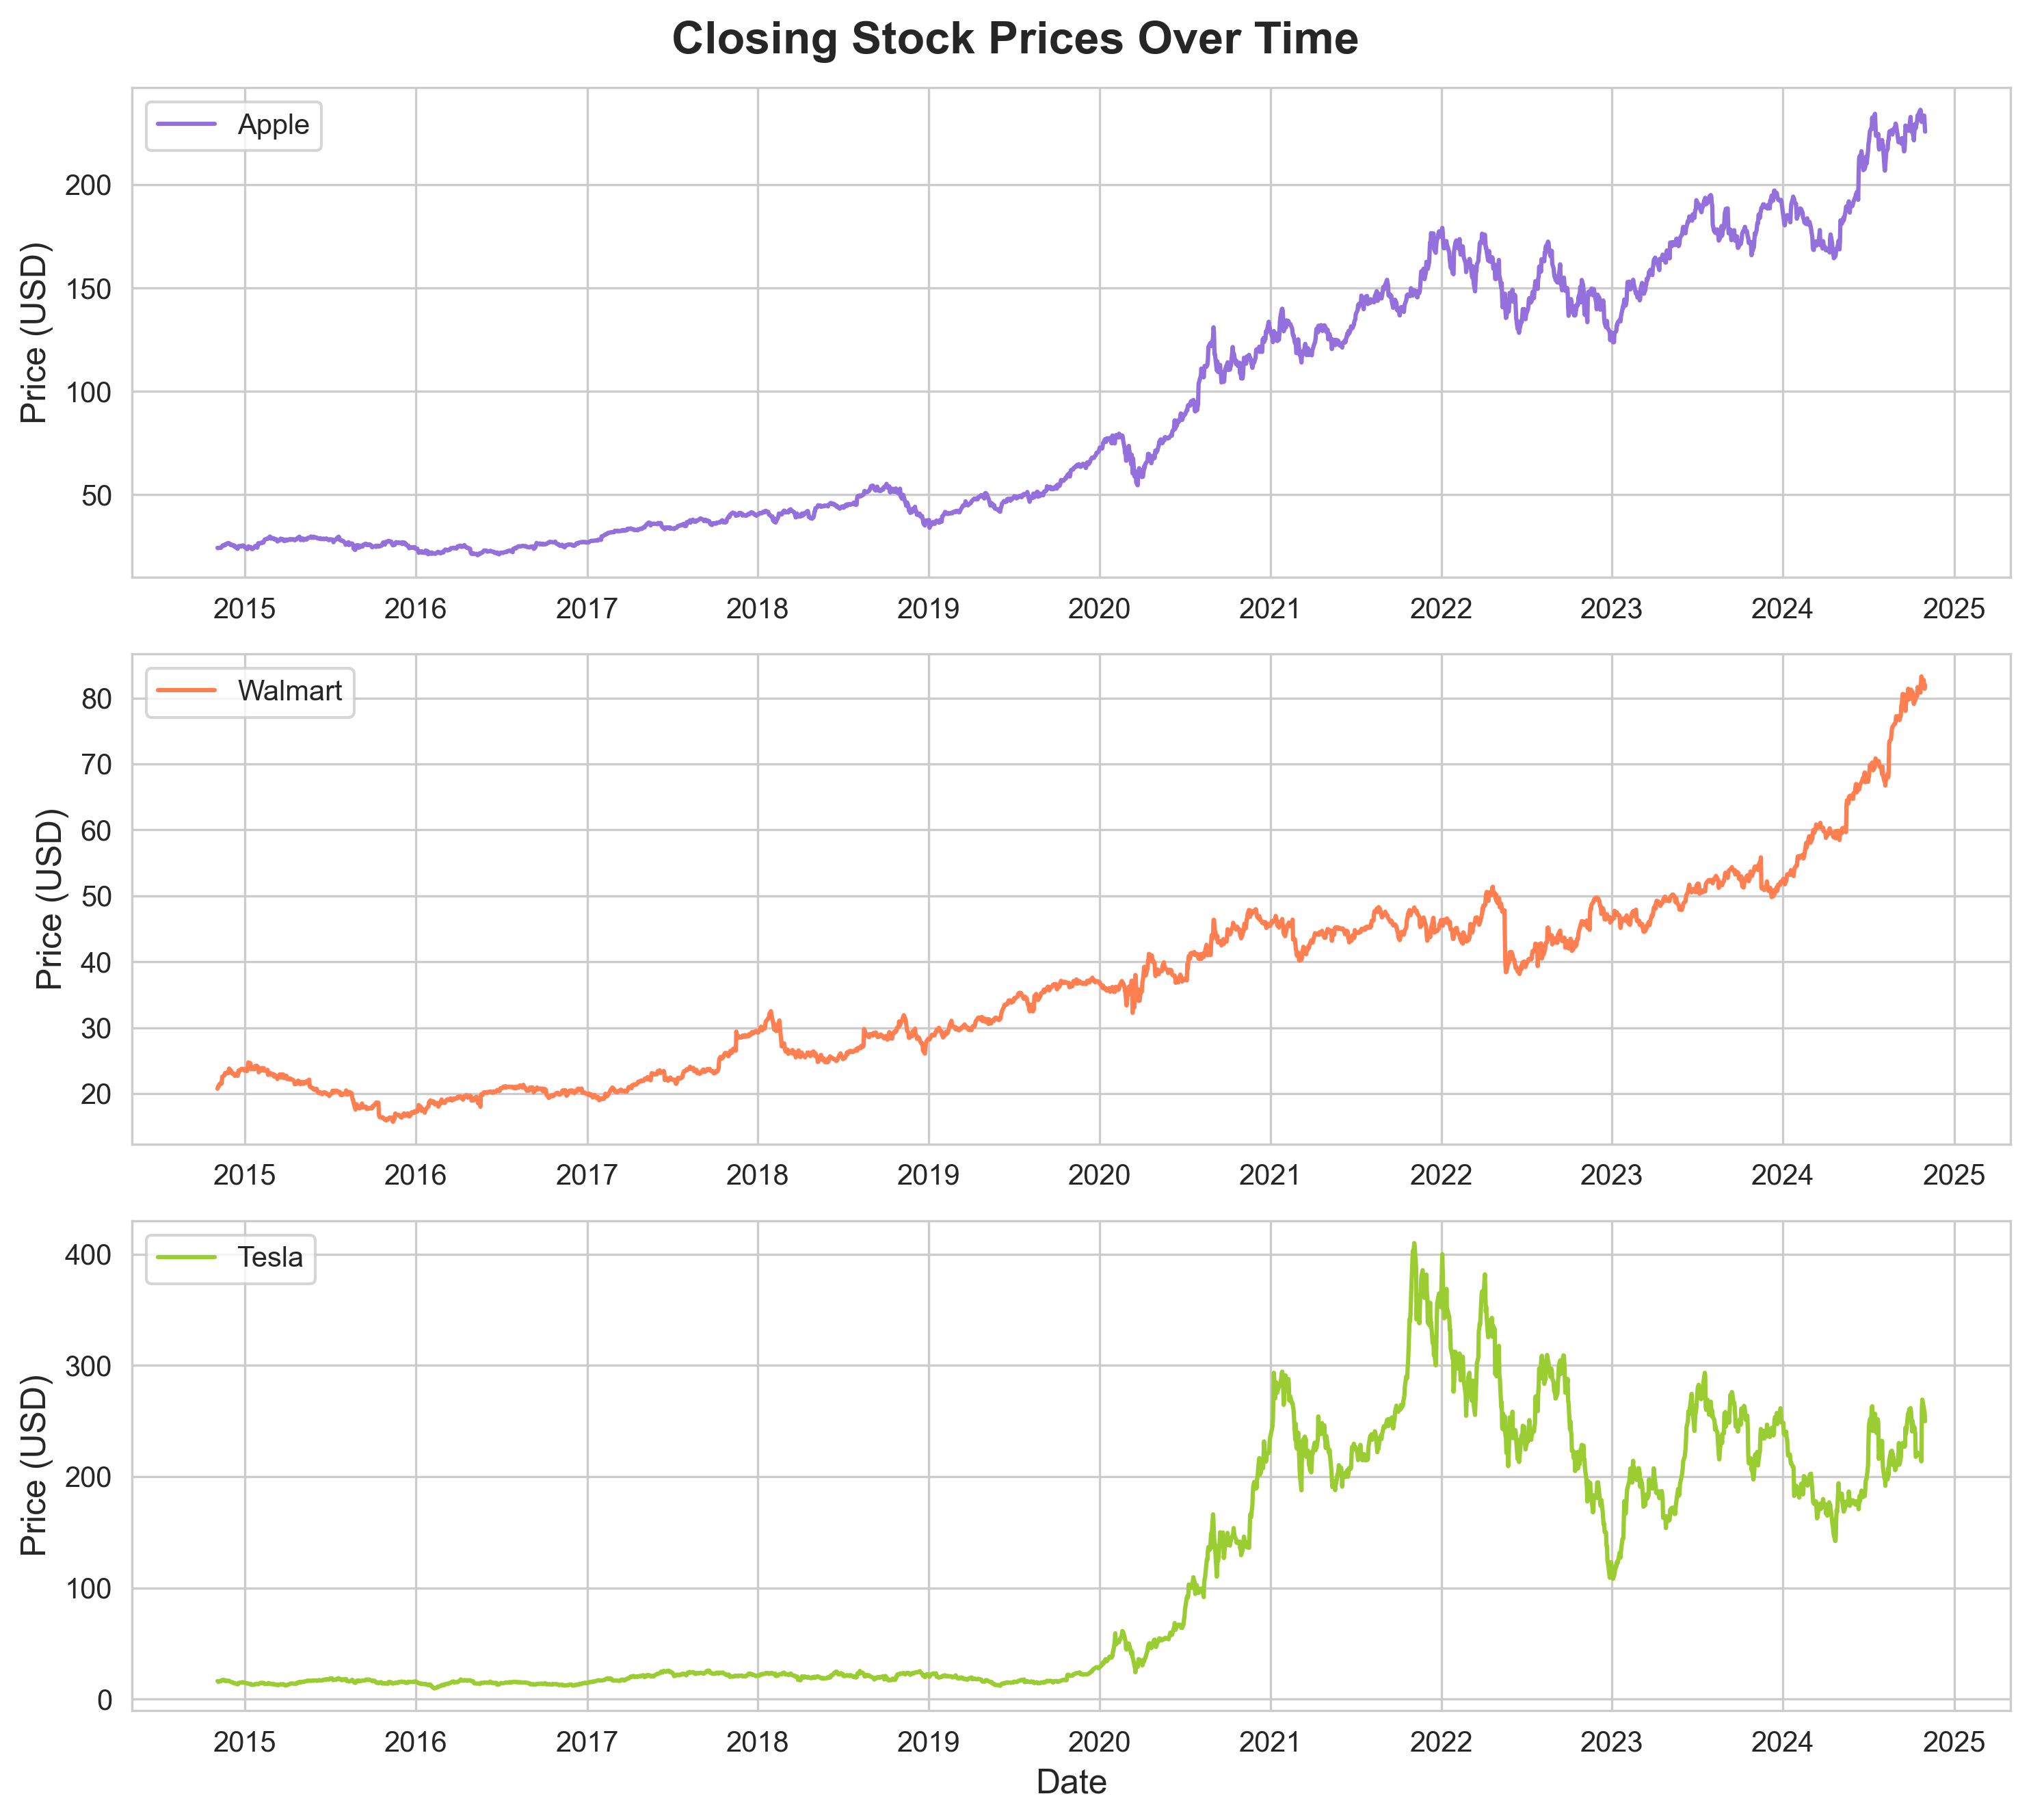

In [6]:
# Visualize data
fig, axes = plt.subplots(3, 1, figsize = (10, 9))

axes[0].plot(df['AAPL'], c='mediumpurple', label='Apple')
axes[1].plot(df['WMT'], c='coral', label='Walmart')
axes[2].plot(df['TSLA'], c='yellowgreen', label='Tesla')

plt.suptitle('Closing Stock Prices Over Time', fontsize=16, weight='bold')

axes[2].set_xlabel('Date', fontsize=12)

for ax in axes:
  ax.set_ylabel('Price (USD)', fontsize=12)
  ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Intuitively, we can infer from the plots that our data is not stationary. We check this using summary statistics.

First, we divide our data into partitions and compare their means and variances. We then use a Kruskal-Wallis test to check if there are statistically significant differences in the medians of the partitions.

$H_0:\text{The time series is stationary.}$

$H_a:\text{The time series is non-stationary.}$

If the p-value (`p_val`) is less than or equal to the significance level (`alpha`), the function concludes that the partitions are significantly different, suggesting non-stationarity of the time series. Otherwise, the function concludes that we cannot reject $H_0$, suggesting that the series is stationary.

In [7]:
def check_stationarity(series, n, alpha=0.05) -> None:
    """
    Evaluates the stationarity of a time series by partitioning it,
    computing summary statistics, and performing a Kruskal-Wallis test.

    Parameters:
    -----------
    series : array-like
        The time series data to be analyzed.
    n : int
        The number of partitions to divide the series into.
    alpha : float, optional (default=0.05)
        The significance level for the Kruskal-Wallis test.
    """
    # Partition the data and compute summary statistics
    partitions = np.array_split(series, n)
    for i, part in enumerate(partitions):
        print(f'Partition {i+1}: median = {part.median()}, variance = {part.var()}')

    # Perform Kruskal-Wallis test
    h_val, p_val = stats.kruskal(*partitions)
    print(f'\nH-statistic: {h_val}, p-value: {p_val}')

    if p_val <= alpha:
        print('Partitions are significantly different —> Non-Stationary Time Series')
    else:
        print('Partitions are not significantly different —> Stationary Time Series')

In [8]:
# Display partition data and check summary statistics
display(Markdown("**Partition data and summary statistics for AAPL**"))
check_stationarity(df['AAPL'], n=5)
print()
display(Markdown("**Partition data and summary statistics for WMT**"))
check_stationarity(df['WMT'], n=5);
print()
display(Markdown("**Partition data and summary statistics for TSLA**"))
check_stationarity(df['TSLA'], n=5)

**Partition data and summary statistics for AAPL**

Partition 1: median = 25.362475395202637, variance = 5.329496468751566
Partition 2: median = 38.29060363769531, variance = 54.390366007691526
Partition 3: median = 58.84391403198242, variance = 560.1631277670076
Partition 4: median = 143.90316772460938, variance = 289.6441012731934
Partition 5: median = 179.58840942382812, variance = 719.613421838058

H-statistic: 2295.395214731552, p-value: 0.0
Partitions are significantly different —> Non-Stationary Time Series



**Partition data and summary statistics for WMT**

Partition 1: median = 20.19063377380371, variance = 4.355369277352009
Partition 2: median = 25.16988754272461, variance = 11.503159043534442
Partition 3: median = 35.9218635559082, variance = 20.90686593172417
Partition 4: median = 44.81291198730469, variance = 6.038804215097193
Partition 5: median = 52.708473205566406, variance = 104.94400588594553

H-statistic: 2297.578543881305, p-value: 0.0
Partitions are significantly different —> Non-Stationary Time Series



**Partition data and summary statistics for TSLA**

Partition 1: median = 14.730999946594238, variance = 2.562079380903312
Partition 2: median = 20.749332427978516, variance = 9.86499342528712
Partition 3: median = 23.166000366210938, variance = 1599.104228204676
Partition 4: median = 251.2133331298828, variance = 2949.1522976571414
Partition 5: median = 205.66000366210938, variance = 1477.158308947353

H-statistic: 2091.852227396253, p-value: 0.0
Partitions are significantly different —> Non-Stationary Time Series


We confirmed that our data is non-stationary.

To be able to use Granger Causality test, we need to have stationary data. One way to make data stationary is to compute the differences between consecutive observations in the original series. This method is called **Differencing**, and can be written as:

$y' = y_t - y_{t-1}$

As it is not possible to find $y'$ for the first observation, the differenced time-series will have $T-1$ values.

In [9]:
# Perform differencing
df_differenced = df.diff().dropna()
df_differenced.head()

,AAPL,WMT,TSLA
Date,,,
2014-11-04,-0.177385,0.266537,-0.243999
2014-11-05,0.057648,0.119675,-0.530667
2014-11-06,0.069035,0.029922,0.683333
2014-11-07,0.069042,0.261091,-0.068001
2014-11-10,-0.040087,0.182224,0.115335


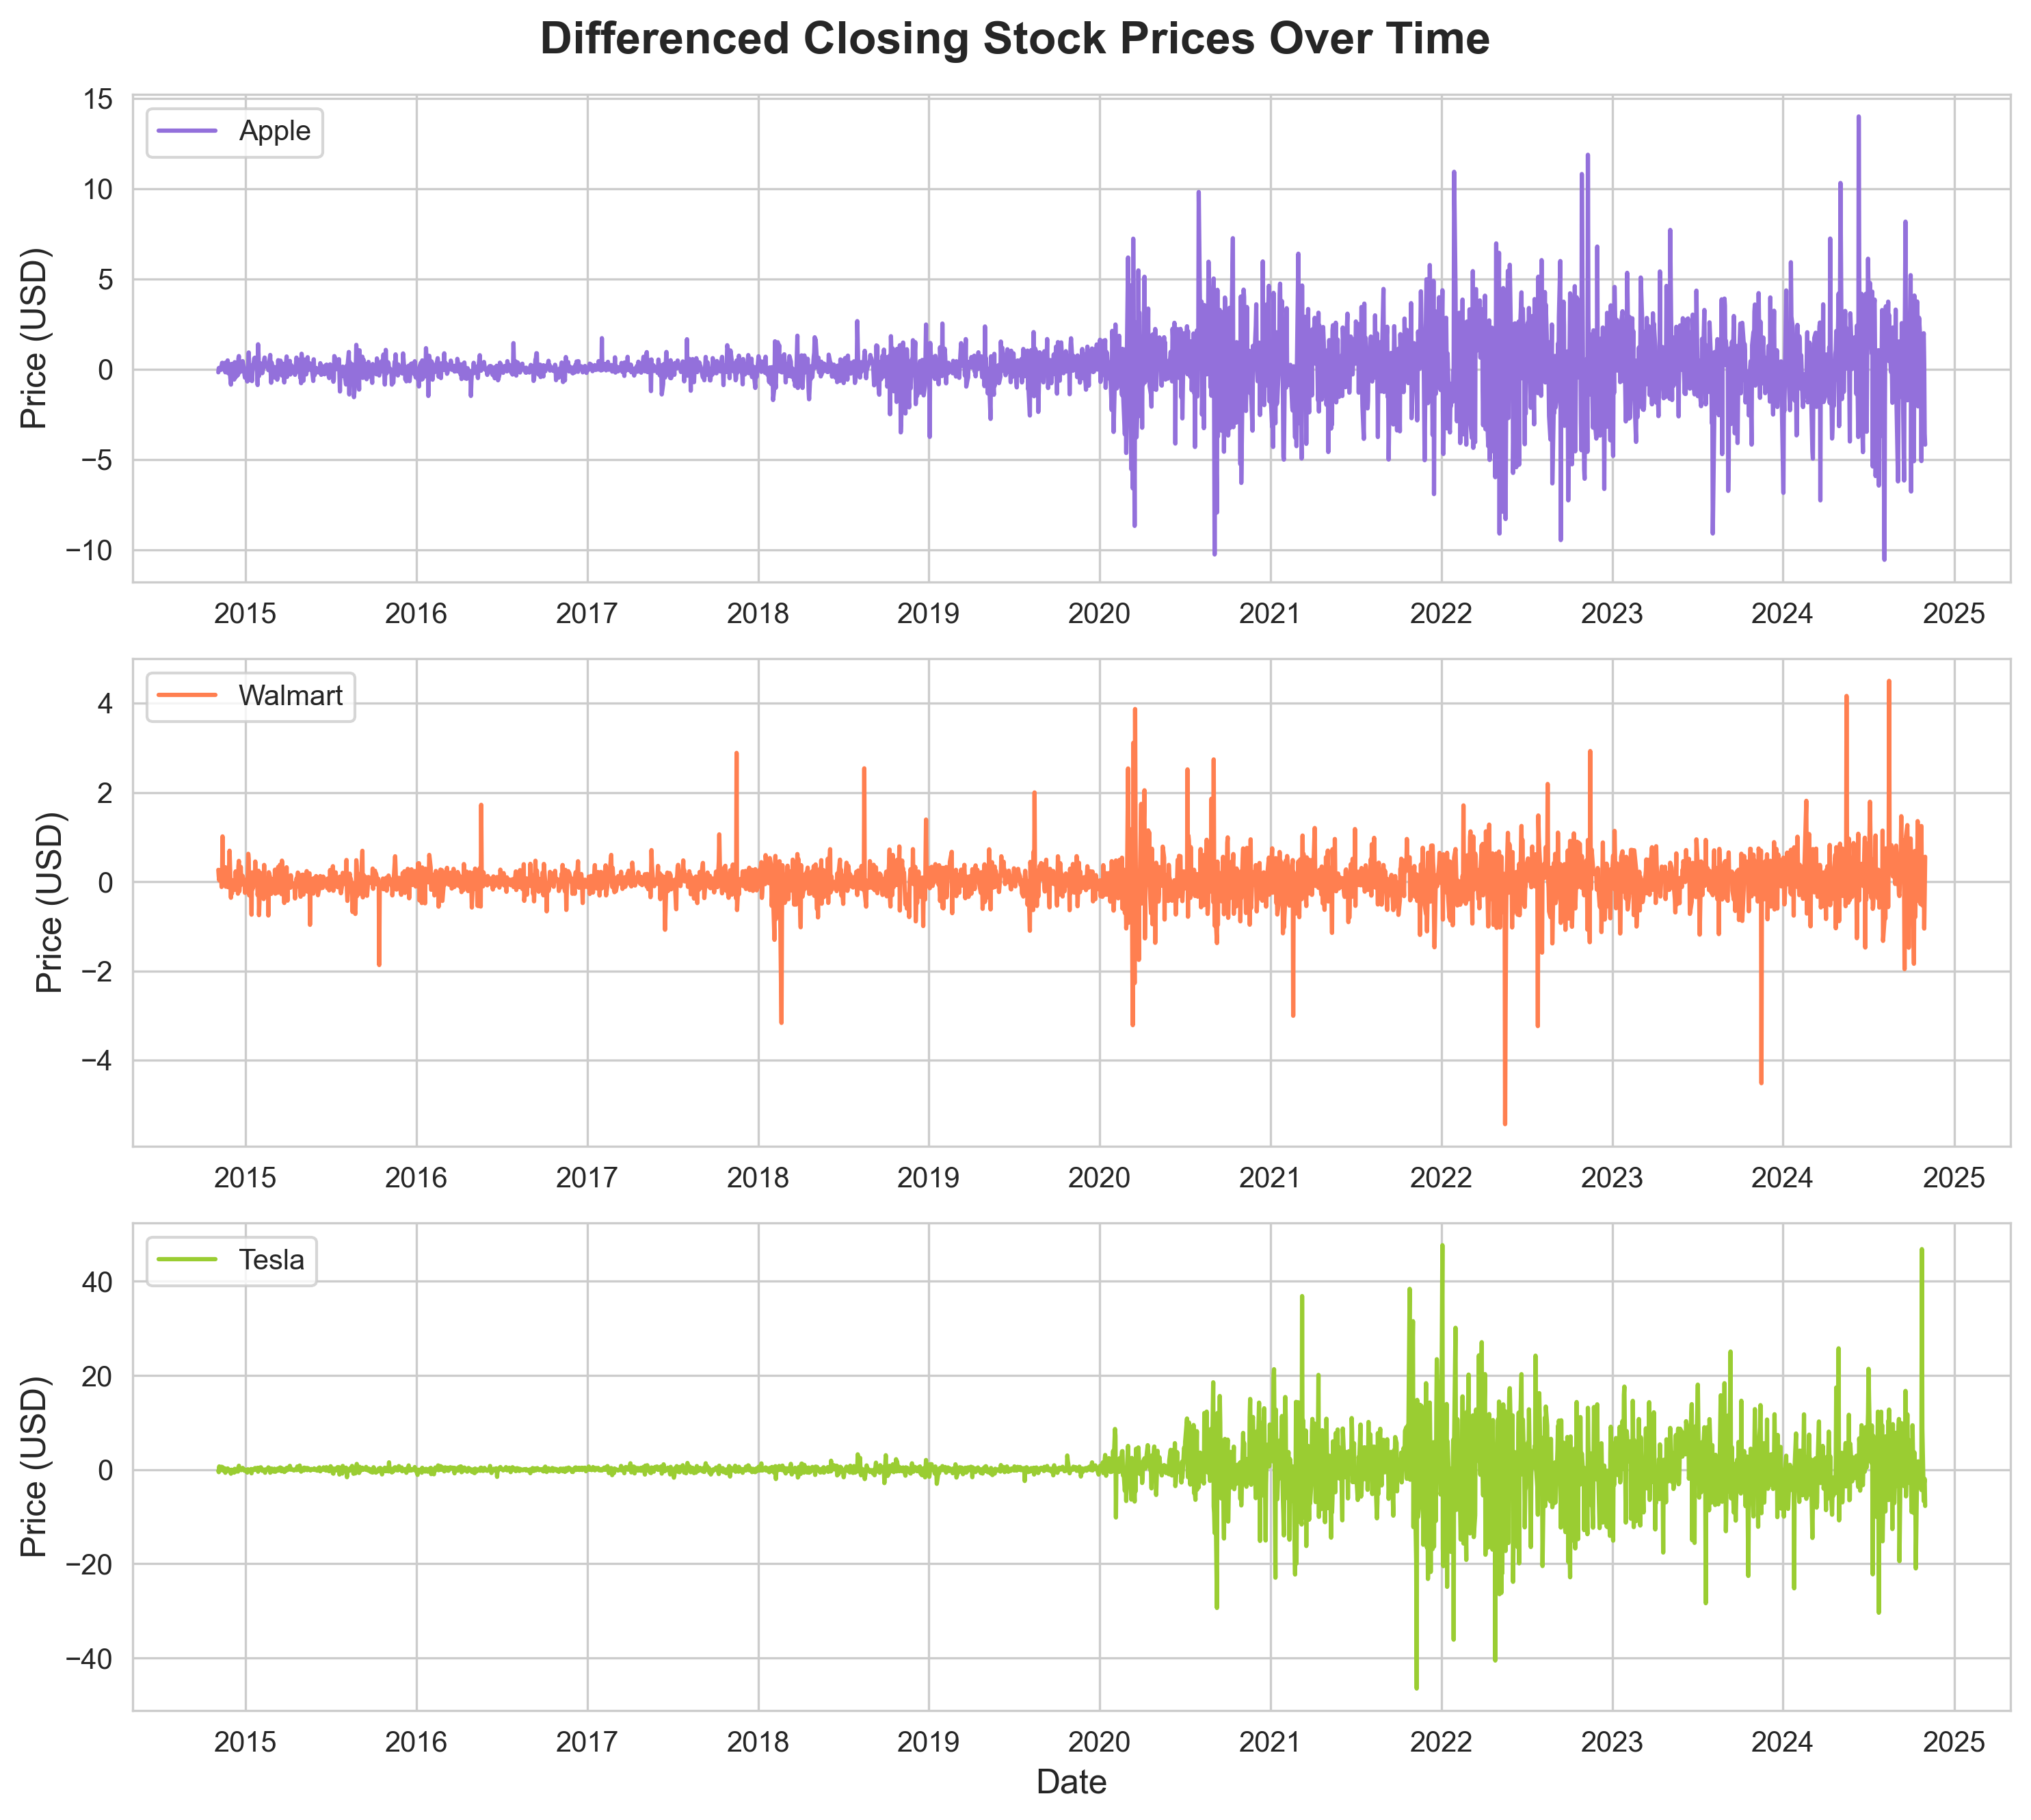

In [10]:
# Plot data after differencing
fig, axes = plt.subplots(3, 1, figsize = (10, 9))

axes[0].plot(df_differenced['AAPL'], c='mediumpurple', label='Apple')
axes[1].plot(df_differenced['WMT'], c='coral', label='Walmart')
axes[2].plot(df_differenced['TSLA'], c='yellowgreen', label='Tesla')

plt.suptitle('Differenced Closing Stock Prices Over Time', fontsize=16, weight='bold')

axes[2].set_xlabel('Date', fontsize=12)

for ax in axes:
  ax.set_ylabel('Price (USD)', fontsize=12)
  ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Visually, our data now looks more stable. We verify this using the `check_stationarity` function:

In [11]:
# Display partition data and check summary statistics for the differenced data
display(Markdown("**Partition data and summary statistics for AAPL**"))
check_stationarity(df_differenced['AAPL'], n=5)
print()
display(Markdown("**Partition data and summary statistics for WMT**"))
check_stationarity(df_differenced['WMT'], n=5);
print()
display(Markdown("**Partition data and summary statistics for TSLA**"))
check_stationarity(df_differenced['TSLA'], n=5)

**Partition data and summary statistics for AAPL**

Partition 1: median = -0.0022754669189453125, variance = 0.15982706661769092
Partition 2: median = 0.030941009521484375, variance = 0.2795511351681104
Partition 3: median = 0.09832000732421875, variance = 3.288955368271804
Partition 4: median = 0.088409423828125, variance = 7.462099778707195
Partition 5: median = 0.2696990966796875, variance = 6.995233852056981

H-statistic: 7.23174436296994, p-value: 0.12413676930034309
Partitions are not significantly different —> Stationary Time Series



**Partition data and summary statistics for WMT**

Partition 1: median = 0.0054988861083984375, variance = 0.06301446444221441
Partition 2: median = 0.026706695556640625, variance = 0.11843164794440826
Partition 3: median = 0.02169036865234375, variance = 0.31665501350936076
Partition 4: median = 0.019123077392578125, variance = 0.3695558413838273
Partition 5: median = 0.062267303466796875, variance = 0.39425641503708975

H-statistic: 9.015145109790412, p-value: 0.06072203806711842
Partitions are not significantly different —> Stationary Time Series



**Partition data and summary statistics for TSLA**

Partition 1: median = -0.005999565124511719, variance = 0.13144986561002583
Partition 2: median = 0.0020008087158203125, variance = 0.35407074839664454
Partition 3: median = 0.08866691589355469, variance = 10.101128841068718
Partition 4: median = 0.53668212890625, variance = 106.228077984573
Partition 5: median = 0.160003662109375, variance = 56.720682132411994

H-statistic: 7.158790162219292, p-value: 0.12773107904977246
Partitions are not significantly different —> Stationary Time Series


Now that our time series meet the stationarity assumption, we can proceed with the test.

### **2. Testing Granger Causality**

### 2.1 Calculating Best Lag Order Using a VAR Model

When testing Granger causality we need to specify the lag order we want to use. The lag order basically defines how many lags (previous values of $X$ and $Y$) of the variables we want to include in our model.

A Vector Autoregressive Model with lag order n (denoted as VAR(n)) is a statistical model used to capture the relationships and interdependencies among multiple time series. Each variable is modeled as a linear function of its own past values and the past values of all other variables in the system.

A VAR(3) model for two variables $X$ and $Y$ has the following shape:

$x_t = c_1 + \sum^{3}_{i=1} \alpha_{1, i} y_{t-i} + \sum^{3}_{i=1} \beta_{1, i}x_{t-i} + \epsilon_{x, t}$

$y_t = c_2 + \sum^{3}_{i=1} \alpha_{2, i} y_{t-i} + \sum^{3}_{i=1} \beta_{2, i}x_{t-i} + \epsilon_{y, t}$

To find the optimal lag order we should first introduce the Akaike Information Criterion (AIC), which is an evaluation measure for model fit, by penalizing model complexity to avoid overfitting.

$AIC = -2ln(L) + 2k$

where $L$ denotes the likelyhood (quality of the fit) of the model and $k$ is the penalty term denoting the number of parameters of the model. We will iterate through different values of (`maxlag`) and aim to minimize the 'AIC' to get the optimal lag order.

In [12]:
var_model = VAR(df_differenced)
lowest_aic = np.inf
lowest_aic_lag = np.nan

for i in range(1, 21):
  result = var_model.fit(i)
  print('Lag order:', i)
  print('AIC : ', result.aic)
  print()
  if result.aic < lowest_aic:
    lowest_aic = result.aic
    lowest_aic_lag = i

print('We have the lowest AIC for Lag order', lowest_aic_lag, ' and the AIC is', lowest_aic)

Lag order: 1
AIC :  3.1426735084335817

Lag order: 2
AIC :  3.1421664261882483

Lag order: 3
AIC :  3.1422829848419718

Lag order: 4
AIC :  3.138839974180027

Lag order: 5
AIC :  3.145640396001901

Lag order: 6
AIC :  3.1513158389792166

Lag order: 7
AIC :  3.1452259168989243

Lag order: 8
AIC :  3.1376465260467863

Lag order: 9
AIC :  3.1339491561459707

Lag order: 10
AIC :  3.135843948365504

Lag order: 11
AIC :  3.1359665787834317

Lag order: 12
AIC :  3.1316969211886776

Lag order: 13
AIC :  3.1325336764096563

Lag order: 14
AIC :  3.138799898083761

Lag order: 15
AIC :  3.139247031880813

Lag order: 16
AIC :  3.143252901315284

Lag order: 17
AIC :  3.144370486891924

Lag order: 18
AIC :  3.1306399571926202

Lag order: 19
AIC :  3.1372415924798767

Lag order: 20
AIC :  3.142851766713164

We have the lowest AIC for Lag order 18  and the AIC is 3.1306399571926202


We will select lag order = 18, since that yields the lowest AIC (~3.1306) score.

In [13]:
results = var_model.fit(maxlags=18, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Dec, 2024
Time:                     12:28:34
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.51541
Nobs:                     2497.00    HQIC:                   3.27034
Log likelihood:          -14372.9    FPE:                    22.8891
AIC:                      3.13064    Det(Omega_mle):         21.4409
--------------------------------------------------------------------
Results for equation AAPL
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.085405         0.039070            2.186           0.029
L1.AAPL         -0.012358         0.023499           -0.526           0.599
L1.WMT          -0.122067         0.079068           -1.544           0.123
L1.TS

Since we are only looking at Granger causality we will only be interested in the Correlation matrix of the residuals and will not interpret the results of our VAR model.

We see that we have a correlation (Pearson) of about:
- $0.475$ between AAPL and TSLA
- $0.258$ between AAPL and WMT
- $0.123$ between WMT and TSLA

The one between AAPL and TSLA is a moderate correlation, but the other are relatively low.

Now, we will introduce the Durbin-Watson test, which measures the presence of autocorrelation (serial correlation) in the residuals of a regression model. This is important so that we can be sure that our model is not biased. The test statistic for large number of observations for this test is

$d = 2 \times (1-\rho)$

where $\rho$ represents the sample autocorrelation of the residuals at lag 1. For the value of $d$ we roughly have $0 \le d \le 4$. A value of $2$ would indicate no autocorrelation, while a higher value indicates negative and a lower positive autocorrelation.

In [14]:
out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

AAPL : 2.0
WMT : 2.0
TSLA : 2.0


We obtain a value close to 2.0, which means that there is no reason to suspect autocorrelation in the residuals. This is important as this indicates that the VAR model properly captures the relationship.

### 2.2 Performing the Granger Causality Test

Granger Causality is a concept developed by Clive Granger in 1969 for analyzing time series data. Since regressions merely reflect correlations Granger was interested in developing a model that can do more. Granger causality is not a measure of causality but a measure of forecasting power, thus is not a "true causality", but a "predictive causality" measure. He test whether *X forecasts Y*. The main assumption behind the Granger Causality test is that the time series data is stationary, but this was already proved in the first part of the notebook.

There are three main assumptions for a Granger Causality Test:  
- The data is stationary
- The residuals do not exhibit autocorrelation
- The residuals are independent

**The mathematical concept of Granger Causality**

First, let's look at the bivariate case of two time series $X$ and $Y$ and let's model them in a VAR(3) case (Vector Autoregressive model with 3 lags):

$x_t = c_1 + \sum^{3}_{i=1} \alpha_{1, i} y_{t-i} + \sum^{3}_{i=1} \beta_{1, i}x_{t-i} + \epsilon_{x, t}$

$y_t = c_2 + \sum^{3}_{i=1} \alpha_{2, i} y_{t-i} + \sum^{3}_{i=1} \beta_{2, i}x_{t-i} + \epsilon_{y, t}$

If we want to determine whether $X$ Granger-causes $Y$ we need to determine whether any lags of $X$ are significant in the model predicting $Y$. For this we need to compare the performance a restricted model for $Y$, where we exclude $X$ with an unrestricted model for $Y$, where we include $X$.

Restricted: $y_t = c_2 + \sum^{3}_{i=1} \alpha_{2, i}y_{t-1} + \epsilon_{y,t}$

Unrestricted: $y_t = c_2 + \sum^{3}_{i=1} \alpha_{2, i} y_{t-i} + \sum^{3}_{i=1} \beta_{2, i}x_{t-i} + \epsilon_{y, t}$

We can perform the Wald test for linear regressions to test the significance of $X$ to our model.

Here we have the following hypotheses:

$H_0: \beta_{2, 1} = \beta_{2, 2} = \beta_{2, 3} = 0$

$H_1: \text{at least one of } \beta_{2, 1}, \beta_{2, 2}, \beta_{2, 3} \neq 0$

Important remarks:
 - The test statistic of the Wald test follows the $\chi^2$ distribution
 - We need to test both $X \Rightarrow Y$ and $X \Leftarrow Y$


In our analysis we will use statsmodels.api's grangercausalitytests method. This method performs multiple test but we will only be interested in the (`ssr_chi2test`), which corresponds to the result of the Wald test. This method performs the test on a DataFrame object given to columns $x$ and $y$ and tests whether $y$ Granger-causes $x$.

In [15]:
# Defining paramaters
maxlag = 18
significance_level = 0.05

# Creating all combinations to examine
stocks = list(df_differenced.columns)
combs = itertools.product(stocks, repeat=2)

# Creating two tables to visualize results
table_vars = pd.DataFrame(0, index=stocks, columns=stocks)
table_granger = pd.DataFrame(0, index=stocks, columns=stocks)

# Iterating through all combinations and performing the Granger Causality Test
for comb in combs:
  stock1, stock2 = comb
  relationship_to_analyze = df_differenced[[stock1, stock2]].copy()
  test_result = grangercausalitytests(relationship_to_analyze, maxlag=maxlag, verbose=False)
  p_values = [round(test_result[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]

  # Getting the number of significant p-values and where Granger Causality is present
  significant_p_values = {}
  min_p_value = np.min(p_values)
  for i in range(maxlag):
    p_val = p_values[i]
    if p_val <= significance_level:
      significant_p_values['lagged var ' + str(i)] = p_val

  # Saving results in the table
  table_granger.loc[stock1, stock2] = 1 if min_p_value <= significance_level else 0
  table_vars.loc[stock1, stock2] = len(significant_p_values)

# Renaming columns and indices for better interpretation
table_granger.columns = [stock + "_x" for stock in stocks]
table_granger.index = [stock + "_y" for stock in stocks]

table_vars.columns = [stock + "_x" for stock in stocks]
table_vars.index = [stock + "_y" for stock in stocks]

# Displaying results
display(Markdown("**Granger Causality of $Y$ on $X$ (1 if exists, 0 if not)**"))
display(table_granger)

print()
print()

display(Markdown("**Number of significant lagged variables for each comparison**"))
display(table_vars)

**Granger Causality of $Y$ on $X$ (1 if exists, 0 if not)**

,AAPL_x,WMT_x,TSLA_x
AAPL_y,0,1,1
WMT_y,1,0,1
TSLA_y,0,1,0


**Number of significant lagged variables for each comparison**

,AAPL_x,WMT_x,TSLA_x
AAPL_y,0,4,6
WMT_y,16,0,11
TSLA_y,0,17,0


Looking at the first table we can conclude that AAPL Granger-causes WMT and TSLA, while WMT Granger-causes AAPL and TSLA, and TSLA Granger-causes WMT. However, looking at the second table and considering the fact that we used (`maxlag = 18`) we can conlude strong evidence for Granger Causality for:
- WMT on APPL
- TSLA on WMT

We can conclude moderate evidence for Granger Causality for:
- WMT on TSLA

We can conclude weak evidence for Granger Causality for:
- AAPL on WMT
- AAPL on TSLA

And we can conclude no evidence for Granger Causality for:
- TSLA on AAPL